In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch, torchvision
import numpy as np

In [3]:
import sys
sys.path.append('../../')

In [4]:
from flow_ssl.invertible import iLogits

In [5]:
def bits_per_dim(x, nll):
    """Get the bits per dimension implied by using model with `loss`
    for compressing `x`, assuming each entry can take on `k` discrete values.
    Args:
        x (torch.Tensor): Input to the model. Just used for dimensions.
        nll (torch.Tensor): Scalar negative log-likelihood loss tensor.
    Returns:
        bpd (torch.Tensor): Bits per dimension implied if compressing `x`.
    """
    dim = np.prod(x.size()[1:])
    bpd = nll / (np.log(2) * dim)

    return bpd

In [6]:
train_dset = torchvision.datasets.CIFAR10('/home/wesley/Documents/datasets/cifar10', train = True, 
                                          transform = torchvision.transforms.ToTensor)

In [7]:
normalized_train = torch.tensor(train_dset.data / 256.).permute(0, -1, -3, -2)
normalized_train = normalized_train.float()

In [8]:
logit_layer = iLogits()

In [9]:
train_logits = logit_layer(normalized_train)
train_logits_2d = train_logits.view(len(train_dset), np.prod(train_logits.size()[1:]))

In [10]:
logdet = logit_layer.logdet()

(array([1.2027e+04, 2.0776e+04, 1.0405e+04, 3.8920e+03, 1.5790e+03,
        7.5700e+02, 3.7100e+02, 1.4800e+02, 3.9000e+01, 6.0000e+00]),
 array([3951.8892, 4414.73  , 4877.571 , 5340.4116, 5803.2524, 6266.093 ,
        6728.9336, 7191.7744, 7654.615 , 8117.456 , 8580.297 ],
       dtype=float32),
 <a list of 10 Patch objects>)

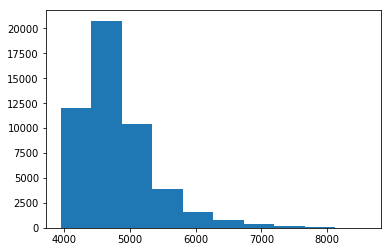

In [11]:
plt.hist(logdet)

In [12]:
cov_mat = torch.FloatTensor(np.cov(train_logits_2d.t().numpy()))
mean_vec = torch.mean(train_logits_2d,0)

In [13]:
# note to self: may want to try https://scikit-learn.org/stable/modules/covariance.html#shrunk-covariance


In [14]:
edist = torch.distributions.MultivariateNormal(mean_vec, cov_mat)

In [15]:
# compute p(x)
ll = edist.log_prob(train_logits_2d)

(array([3.000e+00, 8.000e+00, 2.800e+01, 5.200e+01, 1.270e+02, 3.020e+02,
        9.660e+02, 3.234e+03, 1.363e+04, 3.165e+04]),
 array([-10822.991  ,  -9339.62   ,  -7856.2485 ,  -6372.877  ,
         -4889.506  ,  -3406.1345 ,  -1922.7632 ,   -439.39185,
          1043.9795 ,   2527.3508 ,   4010.7222 ], dtype=float32),
 <a list of 10 Patch objects>)

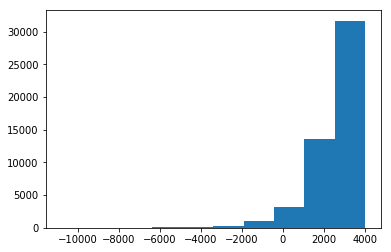

In [16]:
plt.hist(ll)

In [17]:
#p(x) - |J(x,z)|
bits_per_dim(normalized_train, torch.sum(ll - logdet))

tensor(-53586.7539)

In [18]:
# as expected this is about the dumbest thing you could try :)